In [53]:
import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import math

In [54]:
subject_id = "001"
experiment_id = "001"

viewing_distance_cm = 70       # モニタまでの距離
screen_width_cm = 47.6           # モニタの横幅
screen_height_cm = 26.8          # モニタの高さ
diag_length_cm = math.sqrt(screen_width_cm**2 + screen_height_cm**2)

In [55]:
file_path = f"./PsychoData/id{subject_id}/{experiment_id}.csv"
psycho_df = pd.read_csv(file_path)  

In [56]:
exp_start_raw = psycho_df.loc[0, "expStart"]  # 例: "2024-11-25 16h50.12.937293 +0900"
exp_start_cleaned = exp_start_raw.replace("h", ":").replace(".", ":", 1).split(" +")[0]
dt_jst = datetime.strptime(exp_start_cleaned, "%Y-%m-%d %H:%M:%S.%f").replace(tzinfo=ZoneInfo("Asia/Tokyo"))
dt_utc = dt_jst.astimezone(ZoneInfo("UTC"))  # JST → UTC に変換
exp_start_epoch = dt_utc.timestamp()
print(exp_start_epoch)

1732521012.937293


In [57]:
pose_start_sorted = sorted(psycho_df["pose.started"].dropna().unique())
pose_stop_sorted = sorted(psycho_df["pose.stopped"].dropna().unique())

In [58]:
pose1_start = exp_start_epoch + pose_start_sorted[0]
pose1_stop  = exp_start_epoch + pose_stop_sorted[0]

In [59]:
print(pose1_start,pose1_stop)

1732521031.8261118 1732521091.8326926


In [60]:
tobii_filepath = f"./tobiiData/aha-id{subject_id}-{experiment_id}.csv"
tobii_df = pd.read_csv(tobii_filepath)

In [61]:
tobii_df[["left_x", "left_y"]] = tobii_df["left_gaze_point_on_display_area"] \
    .str.strip("()") \
    .str.split(",", expand=True) \
    .astype(float)

tobii_df[["right_x", "right_y"]] = tobii_df["right_gaze_point_on_display_area"] \
    .str.strip("()") \
    .str.split(",", expand=True) \
    .astype(float)

In [62]:
tobii_df["validity_sum"] = (tobii_df["left_gaze_point_validity"] +tobii_df["right_gaze_point_validity"])

In [63]:
tobii_df["datetime"] = pd.to_datetime(
    tobii_df["realtime"],
    format="%Y/%m/%d %H:%M:%S.%f"
).dt.tz_localize("Asia/Tokyo").dt.tz_convert("UTC")
tobii_df["epoch_time"] = tobii_df["datetime"].apply(lambda x: x.timestamp())

In [64]:
# 表示形式を通常の10進数（小数）で表示
pd.set_option('display.float_format', '{:.3f}'.format)

In [65]:
processed_df = tobii_df[[
    "left_x", "left_y",
    "right_x", "right_y",
    "left_gaze_point_validity", "right_gaze_point_validity", "validity_sum",
    "realtime", "epoch_time"
]]

In [66]:
processed_df["mean_x"] = (processed_df["left_x"] + processed_df["right_x"]) / 2
processed_df["mean_y"] = (processed_df["left_y"] + processed_df["right_y"]) / 2



C:\Users\hisao\AppData\Local\Temp\ipykernel_24332\2325693031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df["mean_x"] = (processed_df["left_x"] + processed_df["right_x"]) / 2
C:\Users\hisao\AppData\Local\Temp\ipykernel_24332\2325693031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df["mean_y"] = (processed_df["left_y"] + processed_df["right_y"]) / 2


In [67]:
pose1_df = processed_df[(processed_df["epoch_time"] >= pose1_start) & (processed_df["epoch_time"] <= pose1_stop)].copy()

In [68]:
# pose1_df.to_csv(f"./exported_csv/pose_df/pose1_df_id{subject_id}-{experiment_id}.csv", index=False)

In [69]:
def evaluate_accuracy(df, pose_name):
    total_len = len(df)
    
    # validity_sum == 2 のデータのみを使う
    valid_df = df[df["validity_sum"] == 2].copy()

    valid_df["mean_x"] = (valid_df["left_x"] + valid_df["right_x"]) / 2
    valid_df["mean_y"] = (valid_df["left_y"] + valid_df["right_y"]) / 2
    valid_df = valid_df.dropna(subset=["mean_x", "mean_y"])
    if valid_df.empty:
        raise ValueError("有効なデータがありません。")

    # データ行列
    data = valid_df[["mean_x", "mean_y"]].values

    # 重心
    center = (0.5,0.5)

    # 共分散行列と逆行列
    cov = np.cov(data, rowvar=False)
    inv_cov = np.linalg.inv(cov)

    # 差分
    diff = data - center
    left = np.dot(diff, inv_cov)
    mahal_sq = np.sum(left * diff, axis=1)
    mahal_dist = np.sqrt(mahal_sq)

    # σ=1以内
    within_sigma1 = np.sum(mahal_dist <= 1)
    total_valid = len(mahal_dist)
    percent_sigma1 = 100 * within_sigma1 / total_valid

    # 平均マハラノビス距離
    mahal_mean = np.mean(mahal_dist)

    # ユークリッド距離も参考値で計算（正確度）
    euclid_dist = np.linalg.norm(diff, axis=1)
    euclid_mean = np.mean(euclid_dist)

    # ユークリッド距離→cm→視野角
    euclid_mean_cm = euclid_mean * diag_length_cm
    euclid_mean_deg = np.degrees(np.arctan(euclid_mean_cm / viewing_distance_cm))

    # 結果
    return {
        "subject_id": subject_id,
        "task_id": experiment_id,
        "pose": pose_name,
        "pose_length": total_len,
        "valid_data_count": total_valid,
        "center_x": center[0],
        "center_y": center[1],
        "mahalanobis_mean": mahal_mean,
        "percent_within_sigma1": percent_sigma1,
        "euclid_mean": euclid_mean,
        "euclid_mean_deg": euclid_mean_deg,
    }

In [70]:
summary_list = []
summary_list.append(evaluate_accuracy(pose1_df, "pose1"))


In [71]:
summary_df = pd.DataFrame(summary_list)
summary_df

,subject_id,task_id,pose,pose_length,valid_data_count,center_x,center_y,mahalanobis_mean,percent_within_sigma1,euclid_mean,euclid_mean_deg
0,001,001,pose1,4028,2784,0.500,0.500,0.879,75.682,0.059,2.639


In [72]:
# summary_df.to_csv(f"./exported_csv/pose_df/accuracy_summary_all.csv", index=False)


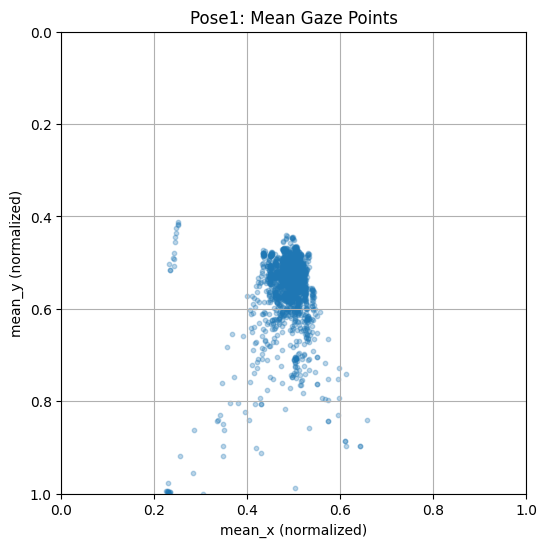

In [73]:
import matplotlib.pyplot as plt



# プロット
plt.figure(figsize=(6, 6))
plt.scatter(pose1_df["mean_x"], pose1_df["mean_y"], alpha=0.3, s=10)
plt.title("Pose1: Mean Gaze Points")
plt.xlabel("mean_x (normalized)")
plt.ylabel("mean_y (normalized)")
plt.xlim(0, 1)
plt.ylim(1, 0)  # Y軸を画面の上から下に反転
plt.grid(True)
plt.show()


